In [1]:
#importy
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import joblib  
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import os, json, uuid, time, math, random
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.amp import autocast, GradScaler
scaler = GradScaler('cuda')

In [2]:
#cesta
CSV_PATH = Path(r"C:\Users\adria\PycharmProjects\pythonProject\ZNEUS\PROJEKT\houses.csv")
CSV_PATH 

WindowsPath('C:/Users/adria/PycharmProjects/pythonProject/ZNEUS/PROJEKT/houses.csv')

# EDA - Data analysis

### Load dataset

In [3]:
df = pd.read_csv(CSV_PATH)

print("Shape:", df.shape)
display(df.head(10))


Shape: (20640, 9)


,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23
1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22
2,352100.0,7.2574,52.0,1467.0,190.0,496.0,177.0,37.85,-122.24
3,341300.0,5.6431,52.0,1274.0,235.0,558.0,219.0,37.85,-122.25
4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25
5,269700.0,4.0368,52.0,919.0,213.0,413.0,193.0,37.85,-122.25
6,299200.0,3.6591,52.0,2535.0,489.0,1094.0,514.0,37.84,-122.25
7,241400.0,3.1200,52.0,3104.0,687.0,1157.0,647.0,37.84,-122.25
8,226700.0,2.0804,42.0,2555.0,665.0,1206.0,595.0,37.84,-122.26
9,261100.0,3.6912,52.0,3549.0,707.0,1551.0,714.0,37.84,-122.25


### Dtypes, missing, duplicates

In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_house_value  20640 non-null  float64
 1   median_income       20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   latitude            20640 non-null  float64
 8   longitude           20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


None

In [5]:
print("Dtypes, missing counts")
dtypes_missing = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "missing_count": df.isna().sum(),
    "missing_rate": (df.isna().mean()).round(4),
    "unique_count": df.nunique(dropna=True)
}).sort_values("missing_count", ascending=False)
display(dtypes_missing)

dups = df.duplicated().sum()
print("Duplicated rows:", dups)


Dtypes, missing counts


,dtype,missing_count,missing_rate,unique_count
median_house_value,float64,0,0.0,3842
median_income,float64,0,0.0,12928
housing_median_age,float64,0,0.0,52
total_rooms,float64,0,0.0,5926
total_bedrooms,float64,0,0.0,1928
population,float64,0,0.0,3888
households,float64,0,0.0,1815
latitude,float64,0,0.0,862
longitude,float64,0,0.0,844


Duplicated rows: 0


### Statistics for numeric columns

In [6]:
num = df.select_dtypes(include=[np.number])
if num.shape[1] > 0:
    display(num.describe().T)
else:
    print("No numeric columns found.")


,count,mean,std,min,25%,50%,75%,max
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20640.0,537.898014,421.247906,1.0000,295.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100


In [7]:
maxv = df['median_house_value'].max()
print("Max value:", maxv, " Count:", (df['median_house_value']==maxv).sum())
df['is_censored'] = (df['median_house_value']==maxv).astype(int)
df['is_censored'].value_counts()


Max value: 500001.0  Count: 965


is_censored
0    19675
1      965
Name: count, dtype: int64

In [8]:
if num.shape[1] > 0:
    iqr = num.quantile(0.75) - num.quantile(0.25)
    range_ = num.max() - num.min()
    outlier_flag = (range_ / (iqr.replace(0, np.nan))).sort_values(ascending=False).head(10)
    print("\nTop features by range / IQR (may indicate heavy tails or outliers):")
    display(outlier_flag)
else:
    print("No numeric columns found.")


Top features by range / IQR (may indicate heavy tails or outliers):


population            38.037313
total_rooms           23.124835
households            18.710769
total_bedrooms        18.306818
median_income          6.651926
median_house_value     3.341960
housing_median_age     2.684211
longitude              2.649077
latitude               2.489418
dtype: float64

### Correlation matrix for numeric features

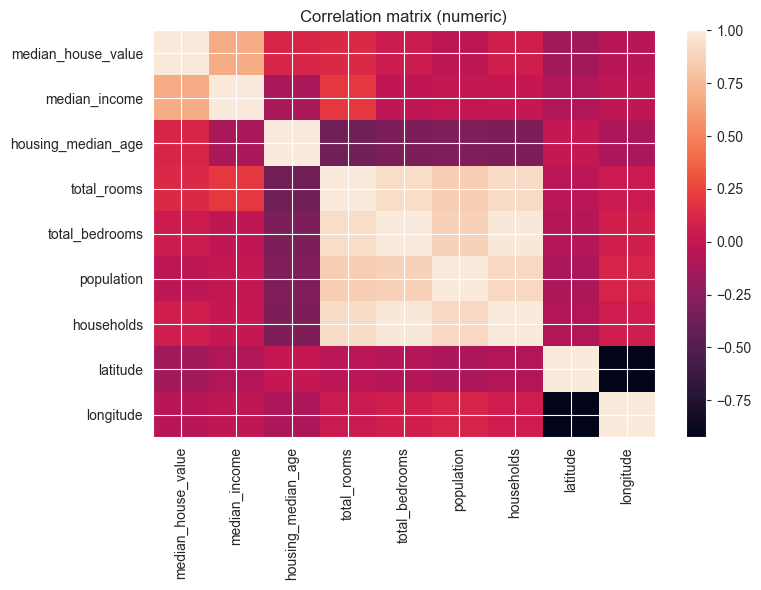

In [9]:
num = df.select_dtypes(include=[np.number]).drop(columns=['is_censored'], errors='ignore')

if num.shape[1] >= 2:
    corr = num.corr(numeric_only=True)
    plt.figure(figsize=(8,6))
    plt.imshow(corr, interpolation="nearest", aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title("Correlation matrix (numeric)")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for correlation matrix.")


In [10]:
target = "median_house_value"
if target in corr.columns:
    target_corr = corr[target].drop(target).abs().sort_values(ascending=False)
    print("Top features by absolute correlation with target:")
    display(target_corr.head(10))
else:
    print("Target not in numeric columns for correlation.")

Top features by absolute correlation with target:


median_income         0.688075
latitude              0.144160
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.050594
longitude             0.045967
population            0.024650
Name: median_house_value, dtype: float64

### Target distribution

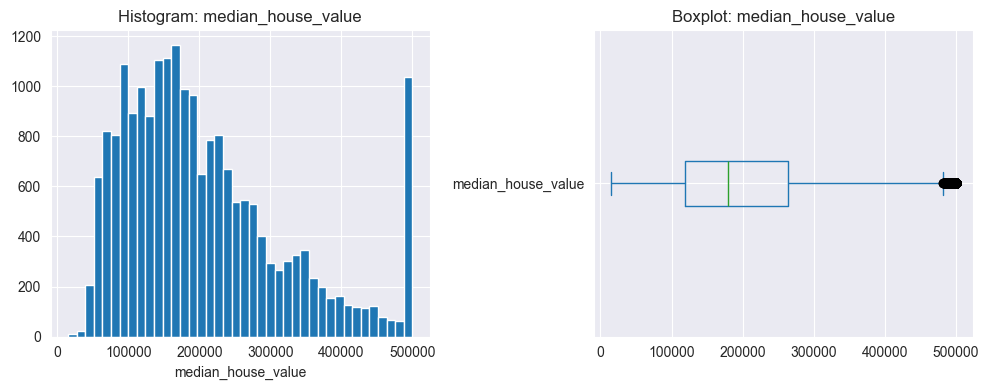

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
df[target].dropna().hist(bins=40)
plt.title(f"Histogram: {target}")
plt.xlabel(target)

plt.subplot(1,2,2)
df[target].dropna().plot.box(vert=False)
plt.title(f"Boxplot: {target}")

plt.tight_layout()
plt.show()


In [12]:
skew = num.skew().sort_values(ascending=False)
display(skew)

population            4.935858
total_rooms           4.147343
total_bedrooms        3.453073
households            3.410438
median_income         1.646657
median_house_value    0.977763
latitude              0.465953
housing_median_age    0.060331
longitude            -0.297801
dtype: float64

In [13]:
kurtosis = num.kurtosis().sort_values(ascending=False)
display(kurtosis)

population            73.553116
total_rooms           32.630927
households            22.057988
total_bedrooms        21.923495
median_income          4.952524
median_house_value     0.327870
housing_median_age    -0.800629
latitude              -1.117760
longitude             -1.330152
dtype: float64

#### Scatter and Pair plots for top numeric features correlated with target

Top numeric features vs target: ['median_income', 'latitude', 'total_rooms']


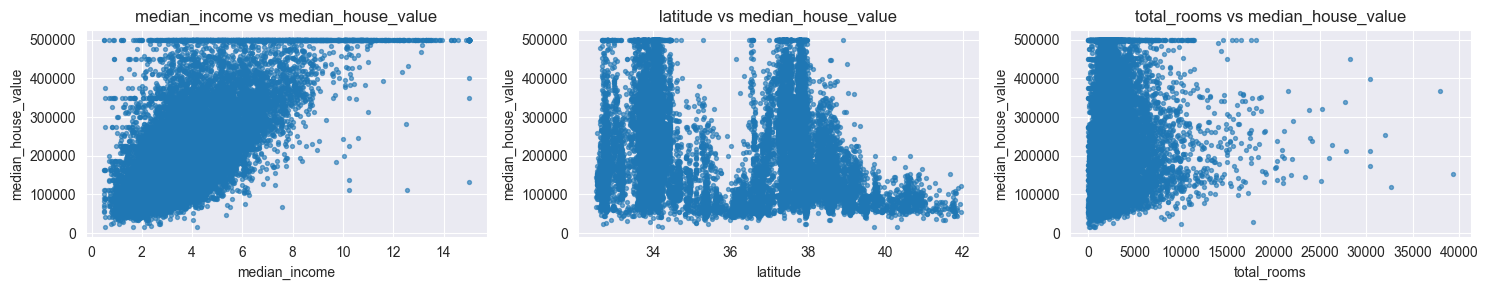

In [14]:
if target in num.columns:
    corr_with_target = num.corr()[target].abs().drop(target).sort_values(ascending=False)
    top_feats = corr_with_target.head(3).index.tolist()
    print("Top numeric features vs target:", top_feats)
    n = len(top_feats)
    if n > 0:
        plt.figure(figsize=(5*n,3))
        for i, f in enumerate(top_feats,1):
            plt.subplot(1,n,i)
            plt.scatter(df[f], df[target], s=8, alpha=0.6)
            plt.xlabel(f); plt.ylabel(target)
            plt.title(f"{f} vs {target}")
        plt.tight_layout()
        plt.show()
else:
    print("Target not numeric or no numeric features.")


### Region exploration

In [15]:
coords = df[['latitude','longitude']]
km = KMeans(n_clusters=8, random_state=0).fit(coords)
df['region_id'] = km.labels_
df.groupby('region_id')['median_house_value'].median().sort_values()


region_id
2     76400.0
4     85800.0
6     89000.0
3    117800.0
7    169650.0
5    181600.0
0    198400.0
1    245100.0
Name: median_house_value, dtype: float64

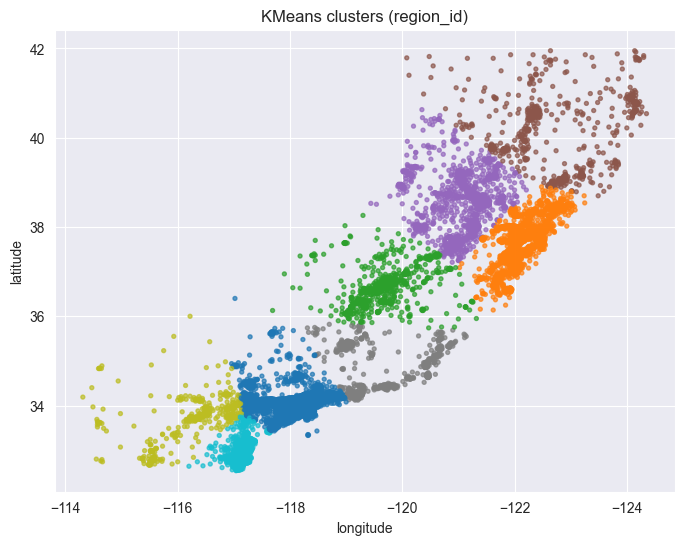

In [16]:
plt.figure(figsize=(8,6))
plt.scatter(df['longitude'], df['latitude'], c=df['region_id'], s=8, cmap='tab10', alpha=0.7)
plt.gca().invert_xaxis()
plt.title("KMeans clusters (region_id)")
plt.xlabel("longitude"); plt.ylabel("latitude")
plt.show()

In [17]:
df.groupby('region_id', observed=False)['median_house_value'].agg(['count','median','mean']).sort_values('median')

,count,median,mean
region_id,,,
2,1117,76400.0,86213.249776
4,685,85800.0,92102.916788
6,474,89000.0,106898.529536
3,2203,117800.0,127250.976396
7,1678,169650.0,198141.446365
5,986,181600.0,191438.676471
0,8652,198400.0,229496.027624
1,4845,245100.0,262594.436739


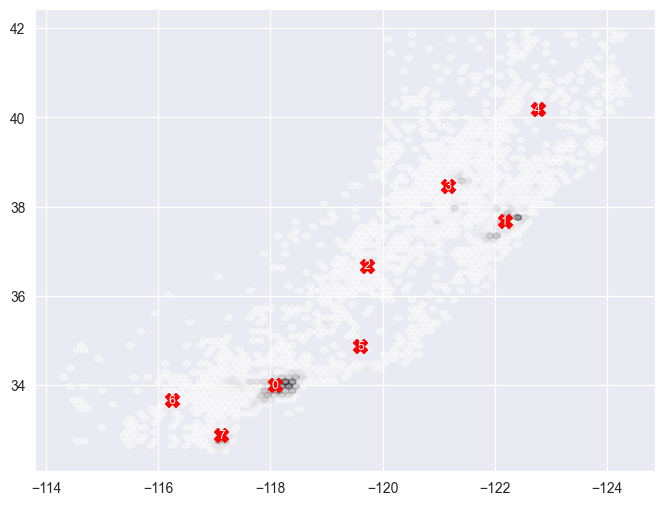

In [18]:
centroids = km.cluster_centers_ 
plt.figure(figsize=(8,6))
plt.hexbin(df["longitude"], df["latitude"], gridsize=80, mincnt=1, cmap='Greys', alpha=0.4)
plt.scatter(centroids[:,1], centroids[:,0], c='red', s=100, marker='X') 
for i,(lon,lat) in enumerate(zip(centroids[:,1], centroids[:,0])):
    plt.text(lon, lat, str(i), color='white', fontsize=9, ha='center', va='center')
plt.gca().invert_xaxis()
plt.show()


### Categorical check

In [19]:
categ = df.select_dtypes(include=["object","category"]).columns.tolist()
if not categ:
    print("No categorical columns found.")
else:
    for c in categ:
        print(f"\nColumn: {c} | Unique: {df[c].nunique()}")
        print(df[c].value_counts().head(5))


No categorical columns found.


## EDA zhrnutie:

- **Veľkosť a čistota dát:** 20 640 riadkov, 9 stĺpcov. V EDA žiadne chýbajúce hodnoty a 0 úplných duplicitných riadkov — dáta sú kompletné a pripravené na ďalšiu analýzu.

- **Cieľ — `median_house_value`:**
  - mean ≈ **206 856**, median ≈ **179 700**, veľký rozptyl.  
  - max = **500001.0**, počet pri maxime = **965**  

- **Hlavné prediktory (lineárne):**
  - `median_income` má najsilnejšiu pozitívnu koreláciu s cenou (~**0.69**) — kľúčový prediktor.  
  - Ďalej sú relevantné priestorové prvky (`latitude`/`longitude`) a štrukturálne metriky domu `total_rooms`...

- **Outliery a šikmosť:**
  - Stĺpce `population`, `total_rooms`, `households`, `total_bedrooms` majú veľký `range / IQR` a vysoký skew → silné chvosty.  
  - `median_house_value` skew ≈ **0.98** (pravostranný).

- **Vizualizácie a priestorový vzor:**
  - Scatter / pairplot potvrdili silný trend `median_income` vs cena a regionálne pásy podľa `latitude`.  
  - Hexbin (longitude vs latitude) ukázal jasné **hotspoty** 

- **Regionálne klastre (KMeans, k=8):**
  - KMeans vytvoril regiony s rôznymi mediánmi
  - Veľkosti klastrov sú nerovnomerné (niektoré stovky, iné tisícky riadkov) — pri použití v modeli zohľadni nerovnomernosť.  
  - Dôležité: KMeans v EDA možno fitnúť na celom df len pre exploráciu


# Data preprocessing and normalization

In [20]:
CONFIG={}
TARGET = "median_house_value"

EXCLUDE = {TARGET, "is_censored"}
if "region_id" in df.columns:
    EXCLUDE.add("region_id")

FEATURES_NUM = (
    df.drop(columns=[c for c in EXCLUDE if c in df.columns], errors="ignore")
      .select_dtypes(include=[np.number])
      .columns.tolist()
)

print(f"Target: {TARGET}")
print(f"Počet numerických features: {len(FEATURES_NUM)}")
print("Features:", FEATURES_NUM)


Target: median_house_value
Počet numerických features: 8
Features: ['median_income', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'latitude', 'longitude']


In [21]:
def suggest_log_cols(frame: pd.DataFrame, cols: list[str], skew_threshold: float = 1.0) -> list[str]:
    skew_vals = frame[cols].skew(numeric_only=True)
    return skew_vals[skew_vals.abs() >= skew_threshold].index.tolist()

def make_preprocess(feature_cols: list[str], log_cols: list[str] | None = None):
    if log_cols is None:
        log_cols = []
    other_cols = [c for c in feature_cols if c not in log_cols]

    col_tf = ColumnTransformer(
        transformers=[
            ("log", FunctionTransformer(np.log1p, validate=False), log_cols),
            ("num", "passthrough", other_cols),
        ],
        remainder="drop"
    )
    preprocess = Pipeline([
        ("cols", col_tf),
        ("scaler", StandardScaler()),
    ])
    return preprocess


In [22]:
LOG_COLS_SUGGESTED = suggest_log_cols(df, FEATURES_NUM, skew_threshold=1.0)
print("Návrh log1p stĺpcov (na celej vzorke):", LOG_COLS_SUGGESTED)


Návrh log1p stĺpcov (na celej vzorke): ['median_income', 'total_rooms', 'total_bedrooms', 'population', 'households']


## Data preprocessing & normalization 
- **Leakage ochrana:** z modelu vylučujem `is_censored` (je odvodený z targetu) a dočasne aj `region_id` z EDA, aby sme netlačili informácie z celej vzorky do tréningu.
- **Výber numerických vstupov:** pracujem len s číselnými stĺpcami po odfiltrovaní `EXCLUDE`.
- **Normalizácia:** budeme používať `StandardScaler` (0-mean, jednotková odchýlka).
- **Stabilizácia rozdelení:** pre stĺpce s vysokou šikmosťou budeme aplikovať `log1p`. Návrh šikmých stĺpcov je v tejto fáze informatívny — skutočné `log_cols` vyberieme **až na tréningovej sade** po splite, aby sme sa vyhli leakage.
- **Pipeline:** definoval som `make_preprocess(...)`, ktorá skombinuje (1) voliteľný `log1p` a (2) škálovanie, aby bol preproces konzistentný v train/val/test aj pri nasadení.


# Data split

In [23]:
try:
    _ds = CONFIG.get("data_split", {})  
    SEED = CONFIG.get("seed", 42)
    TEST_SIZE = _ds.get("test_size", 0.20)
    VAL_SIZE  = _ds.get("val_size",  0.20)
    N_BINS    = _ds.get("strat_bins", 10)
except NameError:
    SEED = 42
    TEST_SIZE = 0.20
    VAL_SIZE = 0.20
    N_BINS = 10

rng = np.random.RandomState(SEED)

In [24]:
X_all = df[FEATURES_NUM].copy()
y_all = df[TARGET].values

y_bins_all = pd.qcut(y_all, q=N_BINS, labels=False, duplicates="drop")

X_trval, X_test, y_trval, y_test, bins_trval, bins_test = train_test_split(
    X_all, y_all, y_bins_all,
    test_size=TEST_SIZE,
    random_state=SEED,
    stratify=y_bins_all
)

bins_trval_local = pd.qcut(y_trval, q=N_BINS, labels=False, duplicates="drop")

X_train, X_val, y_train, y_val = train_test_split(
    X_trval, y_trval,
    test_size=VAL_SIZE,
    random_state=SEED,
    stratify=bins_trval_local
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (13209, 8), Val: (3303, 8), Test: (4128, 8)


In [25]:
def _brief_stats(name, y):
    return pd.Series({
        "n": len(y),
        "mean": float(np.mean(y)),
        "std": float(np.std(y)),
        "min": float(np.min(y)),
        "25%": float(np.quantile(y, 0.25)),
        "50%": float(np.quantile(y, 0.50)),
        "75%": float(np.quantile(y, 0.75)),
        "max": float(np.max(y)),
    }, name=name)

display(pd.concat([
    _brief_stats("train", y_train),
    _brief_stats("val",   y_val),
    _brief_stats("test",  y_test),
], axis=1))


,train,val,test
n,13209.000000,3303.000000,4128.000000
mean,206916.513286,207108.405086,206459.490068
std,115403.069340,115991.929765,114877.300401
min,14999.000000,22500.000000,14999.000000
25%,119600.000000,118900.000000,119875.000000
50%,179700.000000,179700.000000,179650.000000
75%,264500.000000,266000.000000,264900.000000
max,500001.000000,500001.000000,500001.000000


## Data split — čo a prečo
- **Cieľ:** mať train/val/test s podobnou distribúciou cieľa.
- **Metóda:** stratifikácia podľa kvantilov (`pd.qcut`) + `train_test_split` so `stratify`.
- **Pomer:** 20 % **test**, zvyšok rozdelený na **train/val** (20 % z trénovacej časti ide na validáciu).
- **Kontrola:** tabuľka štatistík (n, mean, kvantily) pre `y_train`, `y_val`, `y_test`.


# Configuration

In [26]:
ART_DIR = "artifacts"

Path(ART_DIR).mkdir(parents=True, exist_ok=True)

CONFIG = {
    "seed": SEED,
    "target": TARGET,
    "artifacts_dir": ART_DIR,
    "data_split": {
        "test_size": TEST_SIZE,
        "val_size": VAL_SIZE,
        "strat_bins": N_BINS
    },
    "preprocess": {
        "scaler": "standard",
        "auto_log_skew": True,
        "skew_threshold": 1.0,
        "manual_log_cols": []
    },
    "features": FEATURES_NUM
}

In [27]:
if CONFIG["preprocess"]["auto_log_skew"]:
    log_cols_final = suggest_log_cols(
        X_train, CONFIG["features"], CONFIG["preprocess"]["skew_threshold"]
    )
else:
    log_cols_final = [c for c in CONFIG["preprocess"]["manual_log_cols"]
                      if c in CONFIG["features"]]

CONFIG["preprocess"]["log_cols"] = log_cols_final
print("log_cols (z TRAIN):", CONFIG["preprocess"]["log_cols"])

cfg_json = json.dumps(CONFIG, ensure_ascii=False, indent=2)
print(cfg_json)


log_cols (z TRAIN): ['median_income', 'total_rooms', 'total_bedrooms', 'population', 'households']
{
  "seed": 42,
  "target": "median_house_value",
  "artifacts_dir": "artifacts",
  "data_split": {
    "test_size": 0.2,
    "val_size": 0.2,
    "strat_bins": 10
  },
  "preprocess": {
    "scaler": "standard",
    "auto_log_skew": true,
    "skew_threshold": 1.0,
    "manual_log_cols": [],
    "log_cols": [
      "median_income",
      "total_rooms",
      "total_bedrooms",
      "population",
      "households"
    ]
  },
  "features": [
    "median_income",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "latitude",
    "longitude"
  ]
}


## Configuration — čo a prečo
- **Jedno miesto pravdy:** všetky dôležité nastavenia (seed, cesty, pomery splitu, preproces) sú v `CONFIG`.
- **Features:** explicitne definujem zoznam numerických vstupov po odfiltrovaní potenciálneho leakage.
- **Preprocessing parametre:** voľba škálovača a pravidlá pre `log1p`. Kľúčové je, že **`log_cols` vyberáme z TRAIN** podľa šikmosti (`|skew| ≥ 1.0`), aby sme sa vyhli leakage.


# Experiment tracking

In [28]:

EXP_HISTORY = []

def log_experiment_mem(params: dict, metrics: dict, notes: str = ""):
    run = {
        "run_id": str(uuid.uuid4())[:8],
        "timestamp": int(time.time()),
        "seed": CONFIG["seed"],
        "notes": notes,
        **{f"p_{k}": v for k, v in params.items()},
        **{f"m_{k}": v for k, v in metrics.items()},
    }
    EXP_HISTORY.append(run)
    return run 

In [29]:
preprocess = make_preprocess(CONFIG["features"], CONFIG["preprocess"]["log_cols"])

Xtr = preprocess.fit_transform(X_train)
Xva = preprocess.transform(X_val)
Xte = preprocess.transform(X_test)

baseline = DummyRegressor(strategy="median")
baseline.fit(Xtr, y_train)

def reg_metrics(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae  = float(mean_absolute_error(y_true, y_pred))
    return {"rmse": rmse, "mae": mae}

m_tr = reg_metrics(y_train, baseline.predict(Xtr))
m_va = reg_metrics(y_val,   baseline.predict(Xva))
m_te = reg_metrics(y_test,  baseline.predict(Xte))

display(pd.DataFrame({"train": m_tr, "val": m_va, "test": m_te}))


,train,val,test
rmse,118568.996827,119186.192321,117952.806055
mae,88317.944280,88749.307296,88153.726017


**Experiment tracking**
- Metriky (RMSE, MAE, pre train/val/test) 
- Na konci zobrazím posledné záznamy z pamäte cez `DataFrame`


# Experiments 

In [ ]:
# Počítam, že tieto objekty už existujú z tvojho pipeline:
# CONFIG, Xtr, Xva, Xte, y_train, y_val, y_test, preprocess
for name in ["CONFIG","Xtr","Xva","Xte","y_train","y_val","y_test","preprocess"]:
    assert name in globals(), f"Chýba {name} – najprv spusť časť s preprocess/split."

# GPU only: ak nie je CUDA, zastavíme.
assert torch.cuda.is_available(), "CUDA GPU nie je dostupná. Spusť notebook v GPU prostredí."
DEV = torch.device("cuda:0")

# rýchlosť/konzistencia
SEED = int(CONFIG.get("seed", 42))
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
try:
    torch.set_float32_matmul_precision("high")  # PyTorch 2.x
except Exception:
    pass

print("GPU:", torch.cuda.get_device_name(0))
print("n_features:", Xtr.shape[1])

# fallback metriky, ak ich náhodou nemáš (inak použije tvoje)
if "reg_metrics" not in globals():
    def reg_metrics(y_true, y_pred):
        y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
        rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
        mae  = float(np.mean(np.abs(y_true - y_pred)))
        ss_res = np.sum((y_true - y_pred)**2)
        ss_tot = np.sum((y_true - np.mean(y_true))**2)
        r2 = float(1 - ss_res/(ss_tot + 1e-12))
        return {"rmse": rmse, "mae": mae, "r2": r2}


In [61]:
class ResidualBlock(nn.Module):
    def __init__(self, in_dim, hidden_dim, batchnorm=True, dropout=0.0):
        super().__init__()
        self.bn1  = nn.BatchNorm1d(in_dim) if batchnorm else nn.Identity()
        self.fc1  = nn.Linear(in_dim, hidden_dim)
        self.act  = nn.ReLU()
        self.bn2  = nn.BatchNorm1d(hidden_dim) if batchnorm else nn.Identity()
        self.drop = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.fc2  = nn.Linear(hidden_dim, in_dim)

    def forward(self, x):
        h = self.bn1(x)
        h = self.fc1(h); h = self.act(h)
        h = self.bn2(h); h = self.drop(h)
        h = self.fc2(h)
        return x + h

class TabularMLP(nn.Module):
    def __init__(self, in_dim, hidden_layers=(128,64,32),
                 batchnorm=True, dropout=0.0,
                 residual=False, bottleneck=False):
        super().__init__()

        dims = [in_dim] + list(hidden_layers)
        if bottleneck and len(hidden_layers) >= 2:
            down = list(hidden_layers)
            up   = list(hidden_layers[:-1])[::-1]
            dims = [in_dim] + down + up

        feats = []
        for i in range(len(dims)-1):
            inp, out = dims[i], dims[i+1]
            feats += [nn.Linear(inp, out)]
            if batchnorm: feats += [nn.BatchNorm1d(out)]
            feats += [nn.ReLU()]
            if dropout > 0: feats += [nn.Dropout(dropout)]
            if residual and out >= 16:
                feats += [ResidualBlock(out, max(out//2, 16), batchnorm=batchnorm, dropout=dropout)]
        self.backbone = nn.Sequential(*feats)
        self.head = nn.Linear(dims[-1], 1)

    def forward(self, x):
        return self.head(self.backbone(x)).squeeze(1)


In [62]:
# === Dataloader + tréning/eval s mixed precision (AMP) na GPU ===
# OPRAVY:
# - nové AMP API: from torch.amp import autocast, GradScaler (žiadny deprec. warning)
# - SAFE metriky: ak preds/target obsahuje inf/NaN, vrátime "zlý" výsledok, aby search nespadol

from torch.amp import autocast, GradScaler

# zvoľime dtype pre AMP: keď GPU podporuje BF16, použijeme ho (stabilnejšie), inak FP16
SUPPORTS_BF16 = getattr(torch.cuda, "is_bf16_supported", lambda: False)()
AMP_DTYPE = torch.bfloat16 if SUPPORTS_BF16 else torch.float16

def _to_tensor(x, y):
    return (torch.tensor(x, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32))

def make_loaders(Xtr, ytr, Xva, yva, batch_size=512):
    Xtr_t, ytr_t = _to_tensor(Xtr, ytr)
    Xva_t, yva_t = _to_tensor(Xva, yva)
    tr = TensorDataset(Xtr_t, ytr_t)
    va = TensorDataset(Xva_t, yva_t)
    return (DataLoader(tr, batch_size=batch_size, shuffle=True,  pin_memory=True),
            DataLoader(va, batch_size=batch_size, shuffle=False, pin_memory=True))

def safe_reg_metrics(y_true, y_pred):
    # robustné metriky: ak sa tréning "rozletí", nepadneme na chybe
    yt = np.asarray(y_true, dtype=np.float64).ravel()
    yp = np.asarray(y_pred, dtype=np.float64).ravel()
    if not (np.all(np.isfinite(yt)) and np.all(np.isfinite(yp))):
        return {"rmse": 1e12, "mae": 1e12, "r2": -1.0}
    rmse = float(np.sqrt(np.mean((yt - yp) ** 2)))
    mae  = float(np.mean(np.abs(yt - yp)))
    ss_res = float(np.sum((yt - yp) ** 2))
    ss_tot = float(np.sum((yt - np.mean(yt)) ** 2))
    r2 = float(1 - ss_res / (ss_tot + 1e-12))
    return {"rmse": rmse, "mae": mae, "r2": r2}

def _grad_scaler():
    # pri BF16 scaling netreba; pri FP16 škálujeme
    return GradScaler('cuda') if AMP_DTYPE == torch.float16 else None

def train_epoch(model, loader, opt, loss_fn, max_grad_norm=None, scaler=None):
    model.train(); losses=[]
    for xb, yb in loader:
        xb = xb.to(DEV, non_blocking=True); yb = yb.to(DEV, non_blocking=True)
        opt.zero_grad(set_to_none=True)
        with autocast('cuda', dtype=AMP_DTYPE):
            pred = model(xb)
            loss = loss_fn(pred, yb)
        if scaler is not None:
            scaler.scale(loss).backward()
            if max_grad_norm:
                scaler.unscale_(opt)
                nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(opt); scaler.update()
        else:
            loss.backward()
            if max_grad_norm:
                nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            opt.step()
        losses.append(loss.item())
    return float(np.mean(losses))

@torch.no_grad()
def eval_epoch(model, loader, loss_fn):
    model.eval(); losses=[]; y_true=[]; y_pred=[]
    for xb, yb in loader:
        xb = xb.to(DEV, non_blocking=True); yb = yb.to(DEV, non_blocking=True)
        with autocast('cuda', dtype=AMP_DTYPE):
            pred = model(xb)
            loss = loss_fn(pred, yb)
        losses.append(loss.item())
        y_true.append(yb.cpu().numpy())
        y_pred.append(pred.float().cpu().numpy())
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    return float(np.mean(losses)), safe_reg_metrics(y_true, y_pred), (y_true, y_pred)

DEFAULT_CFG = dict(
    seed=SEED,
    hidden_layers=[128, 64, 32],
    batchnorm=True,
    dropout=0.10,
    residual=False,
    bottleneck=True,
    optimizer="adam",   # "adam" | "rmsprop" | "sgd"
    lr=1e-3,
    weight_decay=1e-4,
    batch_size=512,
    epochs=200,
    patience=20,
    grad_clip=1.0
)

def run_experiment(cfg, Xtr, ytr, Xva, yva, Xte, yte):
    torch.manual_seed(cfg["seed"]); torch.cuda.manual_seed_all(cfg["seed"])
    scaler = _grad_scaler()

    tr_loader, va_loader = make_loaders(Xtr, ytr, Xva, yva, batch_size=cfg["batch_size"])

    model = TabularMLP(
        in_dim=Xtr.shape[1],
        hidden_layers=tuple(cfg["hidden_layers"]),
        batchnorm=cfg["batchnorm"], dropout=cfg["dropout"],
        residual=cfg["residual"], bottleneck=cfg["bottleneck"]
    ).to(DEV)

    if cfg["optimizer"] == "adam":
        opt = torch.optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
    elif cfg["optimizer"] == "rmsprop":
        opt = torch.optim.RMSprop(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
    else:
        opt = torch.optim.SGD(model.parameters(), lr=cfg["lr"], momentum=0.9,
                              nesterov=True, weight_decay=cfg["weight_decay"])

    loss_fn = nn.MSELoss()
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode="min", factor=0.5, patience=max(1, cfg["patience"]//3)
    )

    best_val = float("inf"); best_state=None; patience_left = cfg["patience"]; history=[]
    for epoch in range(1, cfg["epochs"]+1):
        tr_loss = train_epoch(model, tr_loader, opt, loss_fn, max_grad_norm=cfg["grad_clip"], scaler=scaler)
        va_loss, va_m, _ = eval_epoch(model, va_loader, loss_fn)
        sched.step(va_loss)

        history.append({"epoch": epoch, "train_loss": tr_loss, "val_loss": va_loss,
                        **{f"val_{k}": v for k,v in va_m.items()}})

        if va_loss < best_val - 1e-6:
            best_val, patience_left = va_loss, cfg["patience"]
            best_state = {k: v.detach().cpu().clone() if hasattr(v, "detach") else v
                          for k,v in model.state_dict().items()}
        else:
            patience_left -= 1
            if patience_left <= 0:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # full eval
    def _full_eval(X, y):
        loader = DataLoader(TensorDataset(torch.tensor(X, dtype=torch.float32),
                                          torch.tensor(y, dtype=torch.float32)),
                            batch_size=cfg["batch_size"], shuffle=False, pin_memory=True)
        return eval_epoch(model, loader, loss_fn)

    tr_loss, tr_m, _ = _full_eval(Xtr, ytr)
    va_loss, va_m, _ = _full_eval(Xva, yva)
    te_loss, te_m, (y_true_t, y_pred_t) = _full_eval(Xte, yte)

    result = {"train": tr_m, "val": va_m, "test": te_m,
              "best_val_loss": best_val, "epochs_run": len(history)}
    return model, history, result, (y_true_t, y_pred_t)


In [63]:
# === Baseline MLP experiment (GPU) ===
BASE_CFG = DEFAULT_CFG | {
    "hidden_layers": [128, 64, 32],
    "batchnorm": True,
    "dropout": 0.10,
    "residual": False,
    "bottleneck": True,
    "optimizer": "adam",
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "batch_size": 1024,  # GPU zvládne väčší batch (skús aj 512/2048)
    "epochs": 200,
    "patience": 20,
    "grad_clip": 1.0,
}

model, hist, res, (y_true_t, y_pred_t) = run_experiment(
    BASE_CFG, Xtr, y_train, Xva, y_val, Xte, y_test
)

print(pd.DataFrame(res).round(4))

# voliteľné: log do tvojej internej histórie, ak ju máš
if "log_experiment_mem" in globals():
    params = {"model":"MLP-baseline", "n_features_after_pp": int(Xtr.shape[1]), **BASE_CFG}
    metrics = {**{f"train_{k}": v for k,v in res["train"].items()},
               **{f"val_{k}":   v for k,v in res["val"].items()},
               **{f"test_{k}":  v for k,v in res["test"].items()}}
    _ = log_experiment_mem(params, metrics, notes="MLP baseline (GPU)")


KeyboardInterrupt: 

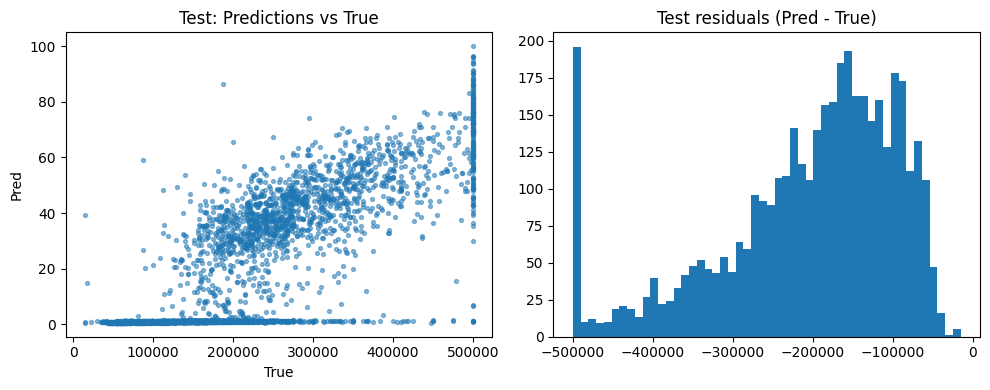

In [34]:
# (voliteľné) rýchle grafy k baseline – Pred vs True + Residuals
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(y_true_t, y_pred_t, s=8, alpha=0.5)
ax[0].set_title("Test: Predictions vs True"); ax[0].set_xlabel("True"); ax[0].set_ylabel("Pred")
resid = y_pred_t - y_true_t
ax[1].hist(resid, bins=50)
ax[1].set_title("Test residuals (Pred - True)")
plt.tight_layout(); plt.show()


In [35]:
# === Random Search (robust) ===
search_space = {
    "hidden_layers": [
        [256,128,64],
        [128,64,32],
        [256,128,64,32],
        [128,64,32,64,128],
    ],,0
    "dropout": [0.0, 0.05, 0.10, 0.20, 0.30],
    "batchnorm": [True, False],
    "residual": [False, True],
    "bottleneck": [False, True],
    "optimizer": ["adam","rmsprop","sgd"],
    "lr": [3e-4, 1e-3],  # tip: drž LR konzervatívne, 3e-3 môže divergnúť pri AMP
    "weight_decay": [0.0, 1e-5, 1e-4, 1e-3],
    "batch_size": [512, 1024, 2048],
    "patience": [10, 20, 30],
}

def _pick(k): return random.choice(search_space[k])

N_TRIALS = 12  # uprav podľa času
rows = []; best = None

for t in range(1, N_TRIALS+1):
    cfg = DEFAULT_CFG | {
        "hidden_layers": _pick("hidden_layers"),
        "dropout":      _pick("dropout"),
        "batchnorm":    _pick("batchnorm"),
        "residual":     _pick("residual"),
        "bottleneck":   _pick("bottleneck"),
        "optimizer":    _pick("optimizer"),
        "lr":           _pick("lr"),
        "weight_decay": _pick("weight_decay"),
        "batch_size":   _pick("batch_size"),
        "patience":     _pick("patience"),
        "seed":         random.randint(1, 10_000),
    }

    try:
        model_i, hist_i, res_i, _ = run_experiment(cfg, Xtr, y_train, Xva, y_val, Xte, y_test)
        row = {"trial": t,
               "val_rmse": res_i["val"]["rmse"], "val_mae": res_i["val"]["mae"], "val_r2": res_i["val"]["r2"],
               "test_rmse":res_i["test"]["rmse"], "test_mae":res_i["test"]["mae"], "test_r2":res_i["test"]["r2"],
               "cfg": cfg, "error": ""}
    except Exception as e:
        # ak sa aj tak niečo pokazí (napr. numerické NaN), zaznač trial ako neúspešný, ale nepádaj
        row = {"trial": t, "val_rmse": 1e12, "val_mae": 1e12, "val_r2": -1.0,
               "test_rmse": 1e12, "test_mae": 1e12, "test_r2": -1.0, "cfg": cfg, "error": repr(e)}
    rows.append(row)

    if best is None or row["val_rmse"] < best["val_rmse"]:
        best = row

res_df = pd.DataFrame(rows).sort_values("val_rmse").reset_index(drop=True)
display(res_df[["trial","val_rmse","val_mae","val_r2","test_rmse","test_mae","test_r2","error"]].round(4))

print("\nNajlepší trial (podľa val_rmse):")
display(res_df.iloc[0])


,trial,val_rmse,val_mae,val_r2,test_rmse,test_mae,test_r2,error
0,8,53175.6909,36226.0321,0.7898,54198.5538,36557.0729,0.7774,
1,4,56498.0816,38825.4526,0.7627,56676.5383,38925.1844,0.7566,
2,12,59663.6625,42533.2600,0.7354,59468.0599,42065.2309,0.7320,
3,6,60881.0492,43408.3984,0.7245,60874.8769,42979.7972,0.7192,
4,5,63292.5534,45227.7402,0.7023,63445.0191,44895.4780,0.6950,
5,9,220137.9969,195617.6433,-2.6019,219433.7060,195213.4354,-2.6487,
6,3,229832.8169,203389.4518,-2.9262,229025.7762,202960.5412,-2.9747,
7,7,237342.6265,207082.5668,-3.1869,236233.5788,206434.2550,-3.2288,
8,1,237355.9206,207084.0859,-3.1874,236246.5485,206435.6977,-3.2292,
9,2,237373.4691,207105.0819,-3.1880,236263.6759,206456.2287,-3.2299,



Najlepší trial (podľa val_rmse):


trial                                                        8
val_rmse                                          53175.690903
val_mae                                           36226.032092
val_r2                                                 0.78983
test_rmse                                          54198.55382
test_mae                                          36557.072917
test_r2                                               0.777409
cfg          {'seed': 8180, 'hidden_layers': [128, 64, 32],...
error                                                         
Name: 0, dtype: object

In [36]:
report = [{"model":"MLP-baseline", **{f"train_{k}":v for k,v in res["train"].items()},
           **{f"val_{k}":v for k,v in res["val"].items()},
           **{f"test_{k}":v for k,v in res["test"].items()}}]

if "res_df" in globals() and len(res_df) > 0:
    top = res_df.iloc[0]
    report.append({"model":"MLP-best-random",
                   "train_rmse":np.nan,"train_mae":np.nan,"train_r2":np.nan,
                   "val_rmse":float(top["val_rmse"]), "val_mae":float(top["val_mae"]), "val_r2":float(top["val_r2"]),
                   "test_rmse":float(top["test_rmse"]), "test_mae":float(top["test_mae"]), "test_r2":float(top["test_r2"])})

report_df = pd.DataFrame(report)
display(report_df.round(4))

md = f"""# Houses – MLP (GPU) – Report

**Techniky:** BatchNorm, Dropout, Residual/Skip, Bottleneck, EarlyStopping, ReduceLROnPlateau, Weight Decay, Grad Clipping, AMP.

**Baseline config:**
```json
{json.dumps(BASE_CFG, indent=2)}


SyntaxError: incomplete input (73851427.py, line 15)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(y_true_t, y_pred_t, s=8, alpha=0.5)
ax[0].set_title("Test: Predictions vs True"); ax[0].set_xlabel("True"); ax[0].set_ylabel("Pred")
resid = y_pred_t - y_true_t
ax[1].hist(resid, bins=50)
ax[1].set_title("Test residuals (Pred - True)")
plt.tight_layout(); plt.show()